In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import utils.gmm_helpers as gmm_helpers
import model_params as params
import resnet

from tensorboardX import SummaryWriter

In [2]:
gmm=torch.load('SavedModels/GMM/gmm_CIFAR10_n1000_data_used50000_augm_flagTrue_alg_scikit.pth')

In [4]:
loader = dl.CIFAR10(train=True,augm_flag=True)
ev.rescale_gmm(gmm, loader)
gmm.logvar.exp().sqrt().mean()

tensor(9.8527, grad_fn=<MeanBackward1>)

In [5]:
X = ev.find_lam(gmm, 0.01, loader)

In [2]:
test_loader = dl.SVHN(train=False,augm_flag=False)
base_model=torch.load('SavedModels/model_baseSVHN_lr0.1_augm_flagTrue_train_typeplain.pth').cpu()
print('loaded')
correct, av_conf, test_loss = tt.test(base_model, 'cpu', test_loader, min_conf=.1)

Using downloaded and verified file: ../data/test_32x32.mat
loaded


In [3]:
df = pd.read_csv('results/model_baseSVHN_lr0.1_augm_flagTrue_train_typeplain.csv')
print(df.to_latex())

\begin{tabular}{llrll}
\toprule
{} &      DataSet &       MMC &               AUROC &               FPR@95 \\
\midrule
0 &        MNIST &  0.987650 &                   - &                    - \\
1 &      CIFAR10 &  0.743120 &  0.9511390999999999 &  0.25619998574256897 \\
2 &     CIFAR100 &  0.736812 &  0.9540600100000001 &  0.24929998815059662 \\
3 &      LSUN\_CR &  0.735161 &              0.9523 &  0.24666666984558105 \\
4 &    Imagenet- &  0.730366 &         0.955624395 &   0.2377999871969223 \\
5 &        Noise &  0.723415 &  0.9675720180840849 &  0.21634380519390106 \\
6 &   Adv. Noise &  0.917751 &  0.4421688196847366 &   0.7025489807128906 \\
7 &  Adv. Sample &  1.000000 &                 0.0 &                  1.0 \\
\bottomrule
\end{tabular}



In [4]:
gmm=torch.load('SavedModels/GMM/gmm_SVHN_n1000_data_used50000_augm_flagTrue_alg_scikit.pth')

model_params = params.params_dict['SVHN'](augm_flag=True)
lam = gmm_helpers.find_lam(gmm, .1, model_params.cali_loader)
print(lam)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat
1776.5617868652344


In [6]:
base_model=torch.load('SavedModels/model_baseSVHN_lr0.1_augm_flagTrue_train_typeplain.pth').cpu()
model = models.RobustModel(base_model, gmm, lam, dim=model_params.dim)
correct, av_conf, test_loss = tt.test(model, 'cpu', model_params.test_loader, min_conf=.1)
print(correct)
print(av_conf)

0.9662722802704364
0.9847904930249561


In [9]:
device = 'cuda:0'
model = model.to(device)
df = ev.evaluate(model, device, 'SVHN', model_params.loaders)
print(df.to_latex())

Using downloaded and verified file: ../data/test_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f278702eb38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 119, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f278702eb38>>
Traceback (most recent call last):
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f278702eb38>>
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.

\begin{tabular}{lrll}
\toprule
{} &       MMC &      AUROC &    FPR@95 \\
DataSet     &           &            &           \\
\midrule
orig        &  0.984791 &          - &         - \\
CIFAR10     &  0.655151 &   0.953954 &    0.2196 \\
CIFAR100    &  0.618495 &   0.958728 &    0.2051 \\
LSUN\_CR     &  0.682799 &   0.945867 &      0.23 \\
Imagenet-   &  0.632350 &   0.957342 &    0.2084 \\
Noise       &  0.722466 &   0.963863 &  0.216864 \\
Adv. Noise  &  0.959212 &    0.24468 &      0.81 \\
Adv. Sample &  0.995500 &  0.0555667 &     0.995 \\
\bottomrule
\end{tabular}



In [8]:
print(correct)
print(av_conf)

0.9691917639827904
0.9876502057710307


In [15]:
model.mm.logvar.exp().mean().sqrt()

tensor(6.3971, grad_fn=<SqrtBackward>)

In [34]:
data = enumerate(model_params.loaders[0][1]).__next__()[1][0]
torch.logsumexp(gmm(data.view(data.shape[0], -1)), 0).mean()

tensor(-4194.6812, grad_fn=<MeanBackward1>)

In [31]:
torch.logsumexp(gmm(data.view(data.shape[0], -1)), 0).mean()

[('CIFAR10', <torch.utils.data.dataloader.DataLoader at 0x7f09ecc0aa20>),
 ('CIFAR100', <torch.utils.data.dataloader.DataLoader at 0x7f09ecc0a080>),
 ('LSUN_CR', <torch.utils.data.dataloader.DataLoader at 0x7f09f1f530b8>),
 ('Imagenet-', <torch.utils.data.dataloader.DataLoader at 0x7f0ae23c5d68>),
 ('Noise', <torch.utils.data.dataloader.DataLoader at 0x7f09f1852d68>)]

In [40]:
model.loglam.data = torch.tensor(-4196.)

In [39]:
data = enumerate(model_params.train_loader).__next__()[1][0]
torch.logsumexp(gmm(data.view(data.shape[0], -1)), 0).mean()

tensor(-4193.0845, grad_fn=<MeanBackward1>)

In [42]:
reload(params)

<module 'model_params' from '/home/alexm/project/notebooks/gmm-robust/model_params.py'>

In [35]:
model = model.to(device)

In [36]:
seed = enumerate(model_params.loaders[-1][1]).__next__()[1][0].to(device)
data = adv.gen_adv_noise(model, device, seed)

In [34]:
device = 'cuda:3'

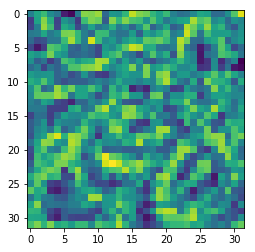

In [39]:
plt.imshow(data[0][0].cpu())

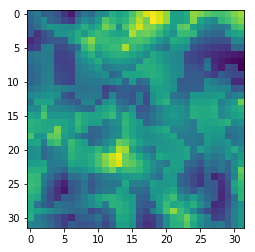

In [41]:
plt.imshow(seed[0][0].detach().cpu())

In [62]:
%timeit data = adv.gen_adv_noise(base_model, device, seed, epsilon=0.3, steps=4)

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

In [63]:
reload(adv)

<module 'utils.adversarial' from '/home/alexm/project/notebooks/gmm-robust/utils/adversarial.py'>

In [64]:
%timeit data = adv.gen_adv_noise(model, device, seed, epsilon=0.3)

6.88 s ± 43.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit
y = base_model(data)
losses = y.max(1)[0]


38.7 ms ± 88.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
%%timeit
y = base_model(data)
losses = y.max(1)[0]
losses.sum().backward()

116 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
device

'cuda:3'

In [87]:
res = resnet.ResNet18().to(device)

In [88]:
%%timeit
y = base_model(data)

39 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [86]:
reload(resnet)

<module 'resnet' from '/home/alexm/project/notebooks/gmm-robust/resnet.py'>

In [89]:
import cprofiler

ImportError: No module named 'cprofiler'